<a href="https://colab.research.google.com/github/juliuserbach/Semantic-Features/blob/master/Mask_R_CNN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ftaubner/semantic_features_detection.git

Cloning into 'semantic_features_detection'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1540 (delta 101), reused 61 (delta 34), pack-reused 1392
Receiving objects: 100% (1540/1540), 114.36 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (953/953), done.


In [0]:
#!wget --no-check-certificate "https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%21100024&authkey=ADLJzehr2ENRggw" -O mapillary_vistas.zip

In [4]:
!wget --no-check-certificate "https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%21101634&authkey=ABTiTiHVXMI06vU"  -O mapillary_prelim.h5

--2020-05-24 10:59:58--  https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%21101634&authkey=ABTiTiHVXMI06vU
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mmhp0a.am.files.1drv.com/y4mmu3cDWgSUqEhJpuSy7FJKbgVR1syguKRFkOkL1sYxZLSbYzyHVHwNlxWflxK3yKbpUcVlhvh3eaoNBbrO1ncQJB19x1xpXe2WJniHY5Icr5ctZvODXfl3I8EPDaqCqJzAYieRXy1Bg65r3je-QhGZu7Qpe3jQGenurnzHAPtwBfZ3oCnz9umwh3INyvEDgjc70DloP0nYs-oM5zX_sphGQ/mask_rcnn_mapvistas_0083.h5?download&psid=1 [following]
--2020-05-24 10:59:59--  https://mmhp0a.am.files.1drv.com/y4mmu3cDWgSUqEhJpuSy7FJKbgVR1syguKRFkOkL1sYxZLSbYzyHVHwNlxWflxK3yKbpUcVlhvh3eaoNBbrO1ncQJB19x1xpXe2WJniHY5Icr5ctZvODXfl3I8EPDaqCqJzAYieRXy1Bg65r3je-QhGZu7Qpe3jQGenurnzHAPtwBfZ3oCnz9umwh3INyvEDgjc70DloP0nYs-oM5zX_sphGQ/mask_rcnn_mapvistas_0083.h5?download&psid=1
Resolving mmhp0a.am.files.1d

In [0]:
#!unzip -qq /content/mapillary_vistas.zip 'mapillary_vistas/validation/*' -d /content

In [0]:
#!unzip -qq /content/mapillary_vistas.zip 'mapillary_vistas/config.json' -d /content

In [7]:
!pip install imgaug
!pip install Cython
!pip install pycocotools

In [8]:
import os
os.chdir('/content/semantic_features_detection/samples/mapillary/cytools')
!python setup.py build_ext --inplace
os.chdir('/content/semantic_features_detection/Notebook')

running build_ext
building 'mask_tools' extension
creating build
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c mask_tools.c -o build/temp.linux-x86_64-3.6/mask_tools.o
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from mask_tools.c:613:
/usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Usin

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
%tensorflow_version 1.x
import tensorflow as tf


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model_felix as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/mapillary/"))  # To find local version
import mapillary_felix

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

TensorFlow 1.x selected.
/content/semantic_features_detection


Using TensorFlow backend.


/content/semantic_features_detection/logs
... done downloading pretrained model!
finished


In [10]:
class_names= ['Unlabeled', 'Bird', 'Ground Animal', 'Curb', 'Fence', 'Guard Rail', 
              'Barrier', 'Wall', 'Bike Lane', 'Crosswalk - Plain', 'Curb Cut', 'Parking', 
              'Pedestrian Area', 'Rail Track', 'Road', 'Service Lane', 'Sidewalk', 'Bridge', 
              'Building', 'Tunnel', 'Person', 'Bicyclist', 'Motorcyclist', 'Other Rider', 
              'Lane Marking - Crosswalk', 'Lane Marking - General', 'Mountain', 'Sand', 
              'Sky', 'Snow', 'Terrain', 'Vegetation', 'Water', 'Banner', 'Bench', 'Bike Rack',
              'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox',
              'Manhole', 'Phone Booth', 'Pothole', 'Street Light', 'Pole', 'Traffic Sign Frame', 
              'Utility Pole', 'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)',
              'Trash Can', 'Bicycle', 'Boat', 'Bus', 'Car', 'Caravan', 'Motorcycle', 'On Rails',
              'Other Vehicle', 'Trailer', 'Truck', 'Wheeled Slow', 'Car Mount', 'Ego Vehicle']
selected_classes = [34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52]

print(selected_classes)

[34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52]


In [11]:
class InferenceConfig(mapillary_felix.mapvistas):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    NUM_CLASSES = len(selected_classes) + 1
config = InferenceConfig()
config.display()
batch_size = config.BATCH_SIZE


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                30
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [0]:
# TRAIN_DIR = '/content/mapillary_vistas'
# # Training dataset
# dataset_train = mapillary.MapillaryDataset()
# dataset_train.load_vistas(dataset_dir=TRAIN_DIR, subset='training', class_ids=selected_classes)
# dataset_train.prepare()

# Validation dataset
VAL_DIR = '/content/drive/My Drive/mapillary_vistas/mapillary_vistas'

dataset_val = mapillary_felix.MapillaryDataset()
dataset_val.load_vistas(dataset_dir=VAL_DIR, subset='validation', config=config, class_ids=selected_classes)
dataset_val.prepare()

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
model_path = '/content/mapillary_prelim.h5'
model.load_weights(model_path, by_name=True)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [0]:
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            
            match_count += 1
            gt_match[j] = i
            pred_match[i] = j
            break

    return gt_match, pred_match, overlaps

new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function
new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


/content/semantic_features_detection/mrcnn/visualize.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


new function


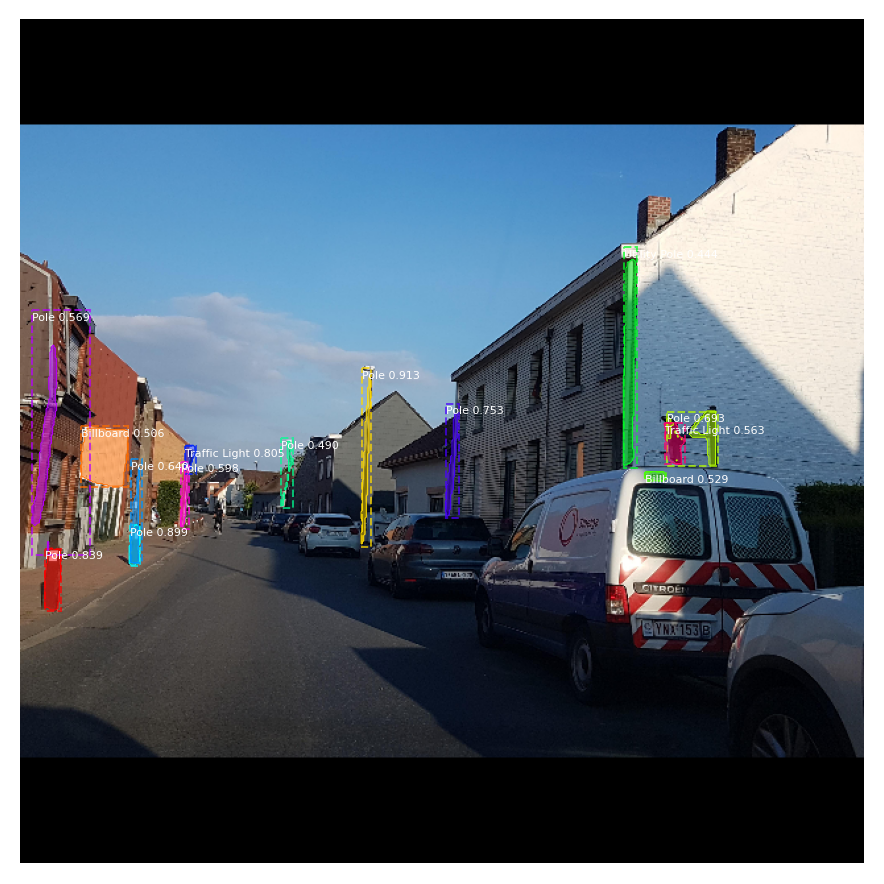

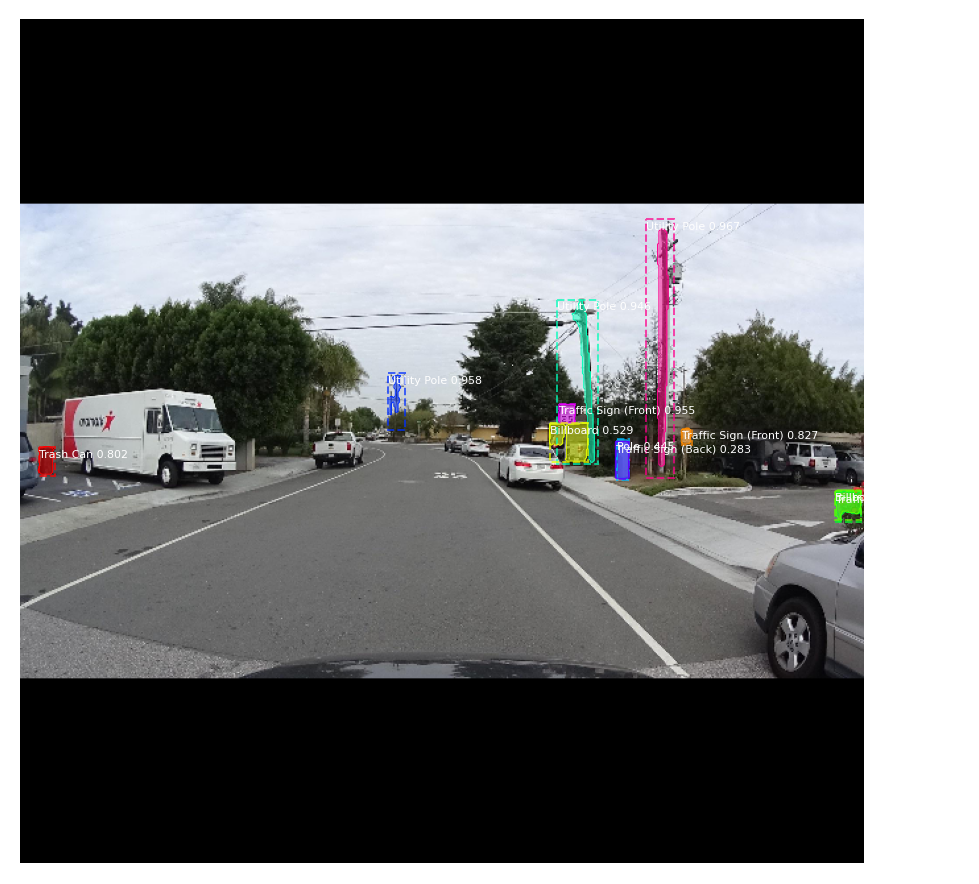

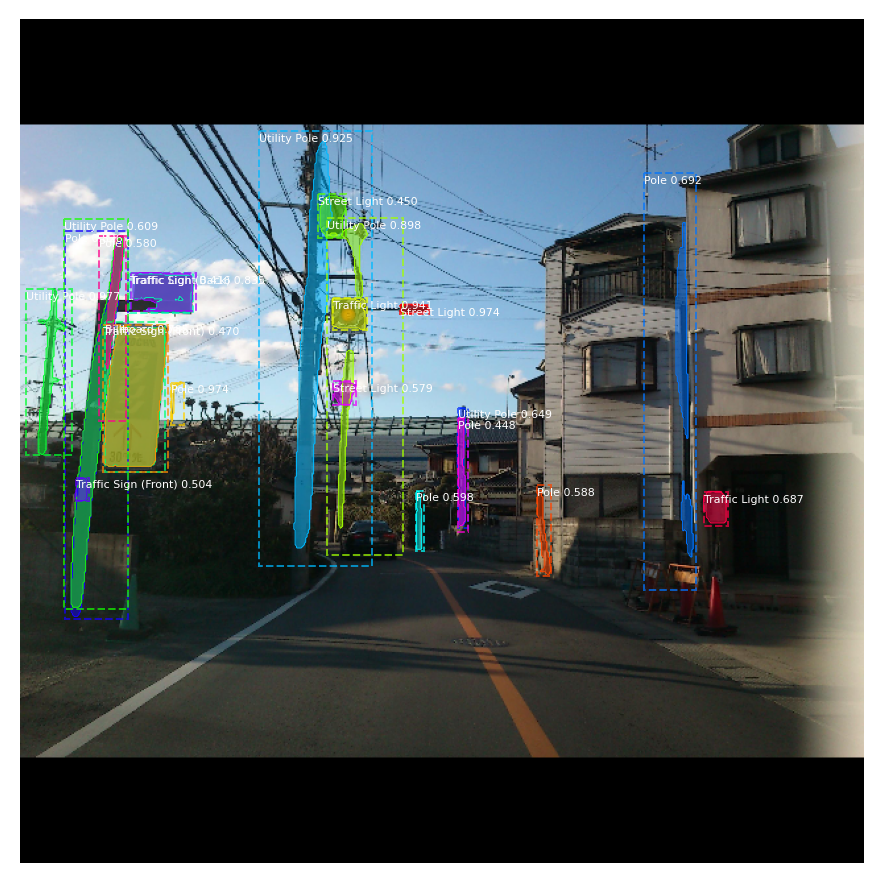

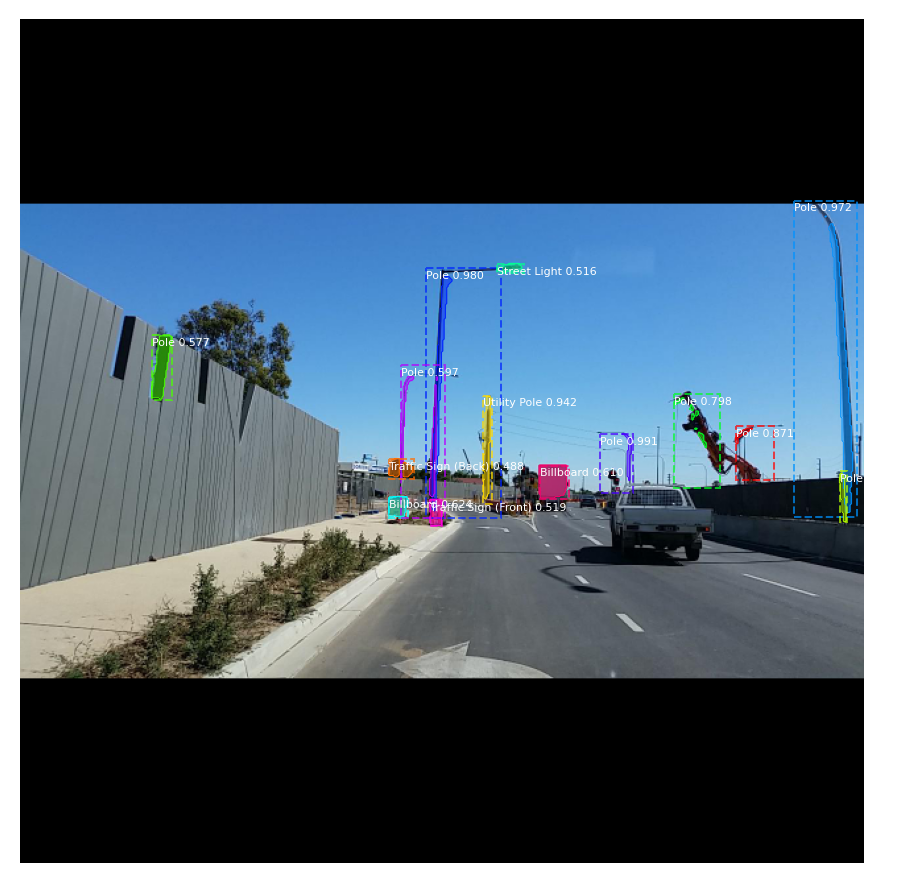

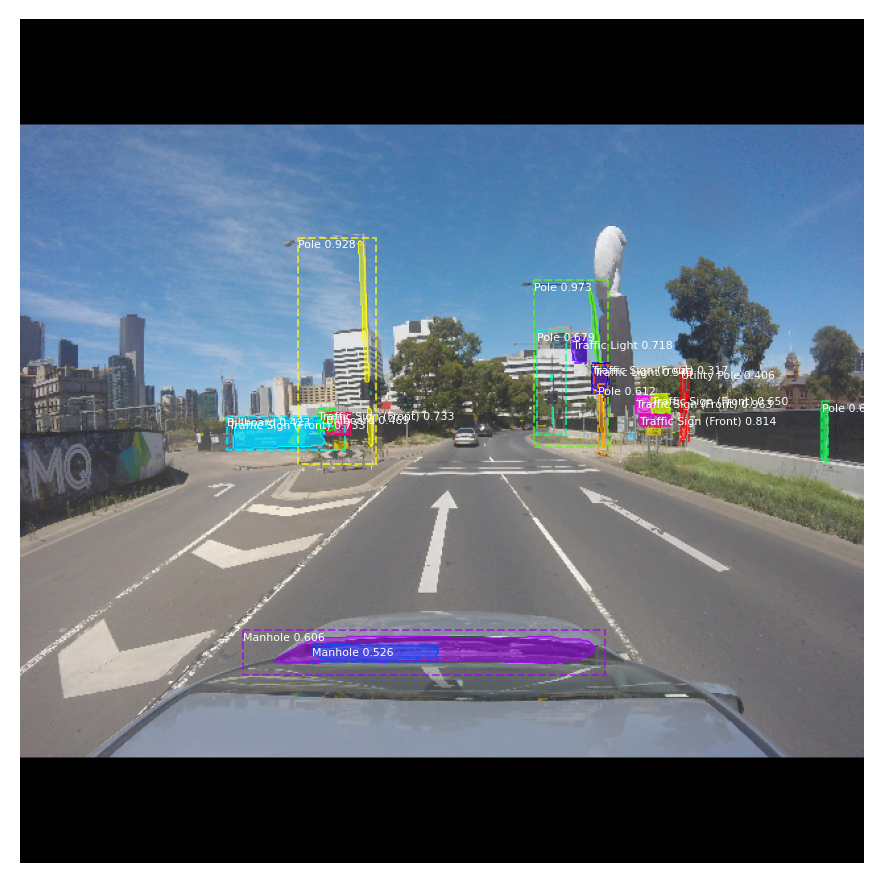

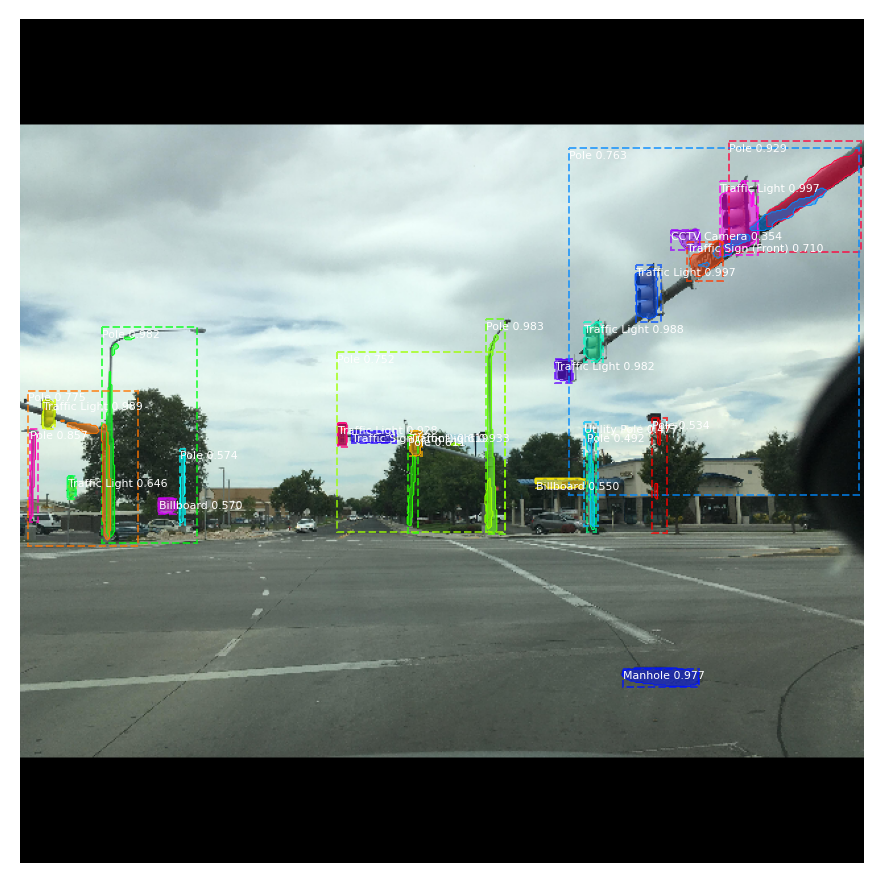

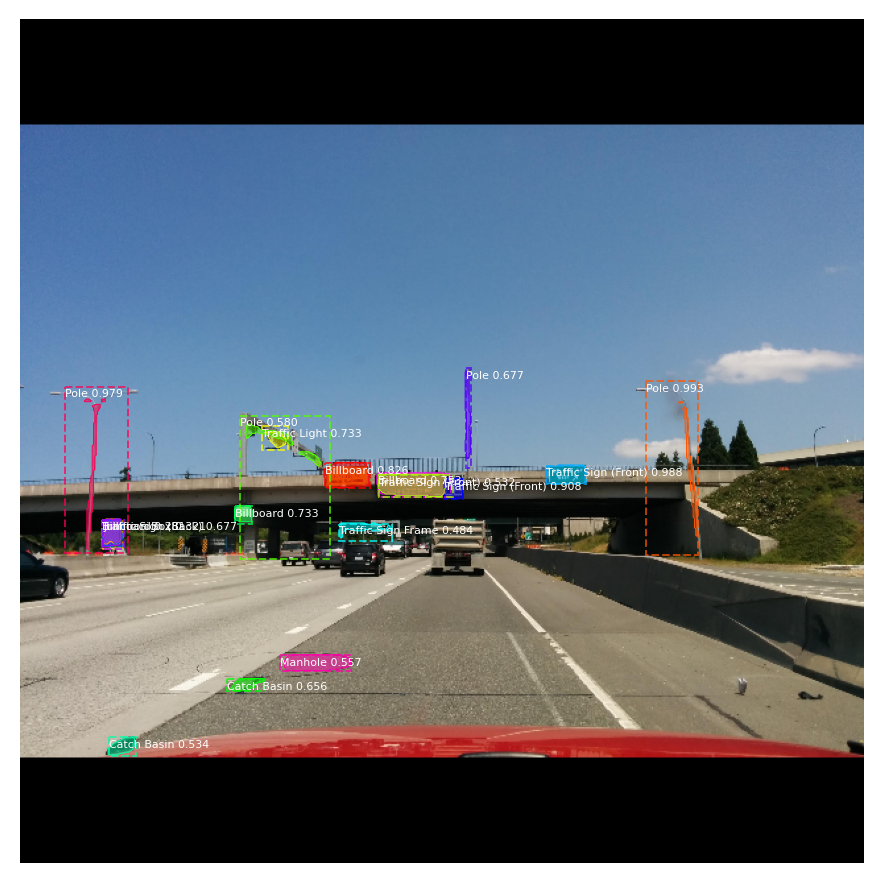

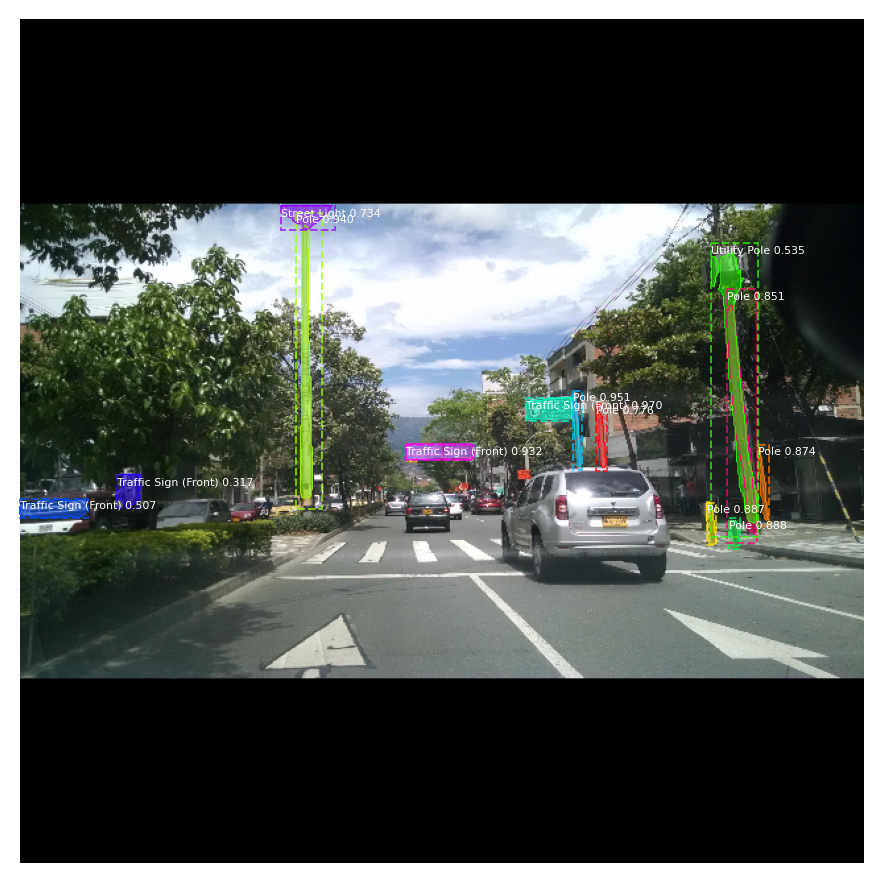

In [0]:
image_ids = np.random.choice(dataset_val.image_ids,40)
class_PMF = np.zeros((len(selected_classes) + 1, (len(selected_classes) + 1)))
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
          modellib.load_image_gt(dataset_val, config,
                                image_id, use_mini_mask=False)
    results = model.detect([image], verbose=0)
    r = results[0]
    #visualize.display_instances(image, boxes=r['rois'], masks=r['masks'], class_ids=r['class_ids'], class_names=dataset_val.class_names[1:], scores=r['scores'])
    gt_match, pred_match, overlaps = compute_matches(gt_boxes=gt_bbox, gt_class_ids=gt_class_id, gt_masks=gt_mask, pred_boxes=r['rois'], 
                          pred_class_ids=r['class_ids'], pred_scores=r['scores'], pred_masks=r['masks'], iou_threshold=0.5)
    
    gt_match = list(map(int, gt_match))
    for i, matched_pred in enumerate(gt_match):
        if matched_pred == -1:  
            class_PMF[gt_class_id[i], 0] += 1 
        else:
            class_PMF[gt_class_id[i], r['class_ids'][matched_pred]] += 1 

    for i, matched_gt in enumerate(pred_match):
        if matched_gt == -1:
            class_PMF[0, r['class_ids'][i]] += 1 
for i, class_Pr in enumerate(class_PMF):
    summed = class_Pr.sum()
    if summed > 0:
        class_PMF[i,:] = class_PMF[i,:]/summed


In [30]:
PMF_dict = {}
for i, class_Pr in enumerate(class_PMF):
    PMF_dict[dataset_val.class_names[i]] = list(class_Pr)
print(PMF_dict)

{'BG': [0.0, 0.21772639691714837, 0.0038535645472061657, 0.0019267822736030828, 0.0038535645472061657, 0.007707129094412331, 0.0, 0.005780346820809248, 0.0, 0.02697495183044316, 0.36801541425818884, 0.005780346820809248, 0.12716763005780346, 0.05394990366088632, 0.04238921001926782, 0.11175337186897881, 0.023121387283236993, 0.0], 'Bench': [0.5825242718446602, 0.3106796116504854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009708737864077669, 0.0970873786407767, 0.0, 0.0], 'Billboard': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Catch Basin': [0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'CCTV Camera': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Fire Hydrant': [0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0], 'Junction Box': [

In [0]:
import json
with open('/content/PMFs.json', 'w') as outfile:
    json.dump(PMF_dict, outfile)


In [0]:
# def compute_batch_ap(image_ids):
#     APs = []
#     for image_id in image_ids:
#         # Load image
#         image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#             modellib.load_image_gt(dataset_val, config,
#                                    image_id, use_mini_mask=False)
#         # Run object detection
#         results = model.detect([image], verbose=0)
#         # Compute AP
#         r = results[0]
#         AP, precisions, recalls, overlaps =\
#             utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                               r['rois'], r['class_ids'], r['scores'], r['masks'])
#         APs.append(AP)
#     return APs

In [0]:
# image_ids = np.random.choice(dataset_val.image_ids, 300)
# APs = compute_batch_ap(image_ids)
# print("mAP @ IoU=50: ", np.mean(APs))

In [0]:
def compute_batch_ap_classwise(image_ids):
    mAPs = np.zeros([len(selected_classes)])
    numAPs = np.zeros([len(selected_classes)])
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, config,
                                  image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        # visualize.display_instances(image, boxes=r['rois'], masks=r['masks'], class_ids=r['class_ids'], class_names=dataset_val.class_names[1:], scores=r['scores'])
        # visualize.display_instances(image, boxes=gt_bbox, masks=gt_mask, class_ids=gt_class_id, class_names=dataset_val.class_names[1:])

        for i, class_id in enumerate(range(17)):
            # Select one class
            mask = np.where(gt_class_id == class_id, True, False)
            gt_class_id_sel = gt_class_id[mask]

            gt_bbox_sel = gt_bbox[mask,:]
            gt_mask_sel = gt_mask[:,:,mask]
                            
            # Select one class
            mask = np.where(r['class_ids'] == class_id, True, False)
            r_rois_sel = r['rois'][mask,:]
            r_class_ids_sel = r['class_ids'][mask]
            r_scores_sel = r['scores'][mask]
            r_masks_sel = r['masks'][:,:,mask] 
            if len(gt_class_id_sel) != 0:
                AP, precisions, recalls, overlaps =\
                    utils.compute_ap(gt_bbox_sel, gt_class_id_sel, gt_mask_sel,
                                      r_rois_sel, r_class_ids_sel, r_scores_sel, r_masks_sel)
                print("precisions: {}".format(precisions))
                mAPs[i] = mAPs[i] + AP
                # print("mAPs: {}".format(mAPs))
                numAPs[i] += 1
                # print("numAPs: {}".format(numAPs))

    # print("mAPs: {}".format(mAPs))
    # print("numAPs: {}".format(numAPs))
    mAPs = mAPs / numAPs
    return mAPs

In [21]:
image_ids = np.random.choice(dataset_val.image_ids,2)
# image_ids = [50]
APs = compute_batch_ap_classwise(image_ids)
print("mAP @ IoU=50: ", APs)

precisions: [0. 0. 0. 0. 0. 0.]
precisions: [1. 1. 0.]
precisions: [1.         1.         1.         0.66666667 0.5        0.5
 0.5        0.        ]
precisions: [1.   1.   1.   1.   0.75 0.6  0.5  0.  ]
precisions: [1.   1.   1.   1.   0.75 0.  ]
mAP @ IoU=50:  [       nan        nan        nan        nan        nan        nan
        nan        nan        nan 1.         0.50000001        nan
 0.         0.75              nan 1.                nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


In [22]:
mAP_opt = 0
thresh_opt = 0
class_id = 9
image_ids = np.random.choice(dataset_val.image_ids,500)

for thresh in range(20):
    thresh = thresh/20
    mAP = compute_batch_ap_classwise_thresh(image_ids, class_id, thresh)
    print(mAP)
    print(thresh)
    if mAP > mAP_opt:
        mAP_opt = mAP
        thresh_opt = thresh

NameError: ignored

In [0]:
print(mAP_opt)
print(thresh_opt)

In [0]:
SAVE_DIR = '/content/Results'
image_ids = np.random.choice(dataset_val.image_ids,4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    visualize.save_image(image = image[:,:,::-1], image_name=image_id, boxes=r['rois'], masks=r['masks'], class_ids=r['class_ids'], class_names=class_names, scores=r['scores'], save_dir=SAVE_DIR)

In [0]:
class_names = ['Bench', 'Billboard', 'Catch Basin', 'CCTV Camera', 'Fire Hydrant', 'Junction Box', 'Mailbox',
               'Manhole', 'Phone Booth', 'Street Light', 'Pole', 'Traffic Sign Frame', 'Utility Pole',
               'Traffic Light', 'Traffic Sign (Back)', 'Traffic Sign (Front)', 'Trash Can']
print(dataset_val.class_names[1:])

In [0]:
for i in range(len(APs)):
    print("class name: {}: mAP: {}".format(class_names[i], APs[i]))


In [0]:
def compute_batch_ap_classwise_thresh(image_ids, class_id, thresh):
    mPs = 0
    numPs = 0
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, config,
                                  image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        # visualize.display_instances(image, boxes=r['rois'], masks=r['masks'], class_ids=r['class_ids'], class_names=dataset_val.class_names[1:], scores=r['scores'])
        # visualize.display_instances(image, boxes=gt_bbox, masks=gt_mask, class_ids=gt_class_id, class_names=dataset_val.class_names[1:])

    
        # Select one class
        mask = np.where(gt_class_id == class_id, True, False)
        gt_class_id_sel = gt_class_id[mask]

        gt_bbox_sel = gt_bbox[mask,:]
        gt_mask_sel = gt_mask[:,:,mask]
                        
        # Select class and scores higher than threshold
        mask = np.where(np.logical_and(r['class_ids'] == class_id, r['scores'] > thresh), True, False)
        r_rois_sel = r['rois'][mask,:]
        r_class_ids_sel = r['class_ids'][mask]
        r_scores_sel = r['scores'][mask]
        r_masks_sel = r['masks'][:,:,mask] 
        if len(r_class_ids_sel) != 0:
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox_sel, gt_class_id_sel, gt_mask_sel,
                                  r_rois_sel, r_class_ids_sel, r_scores_sel, r_masks_sel)
            mPs = mPs + precisions[-2]
            numPs += 1

    print("numPs: {}".format(numPs))
    mPs = mPs / numPs
    return mPs